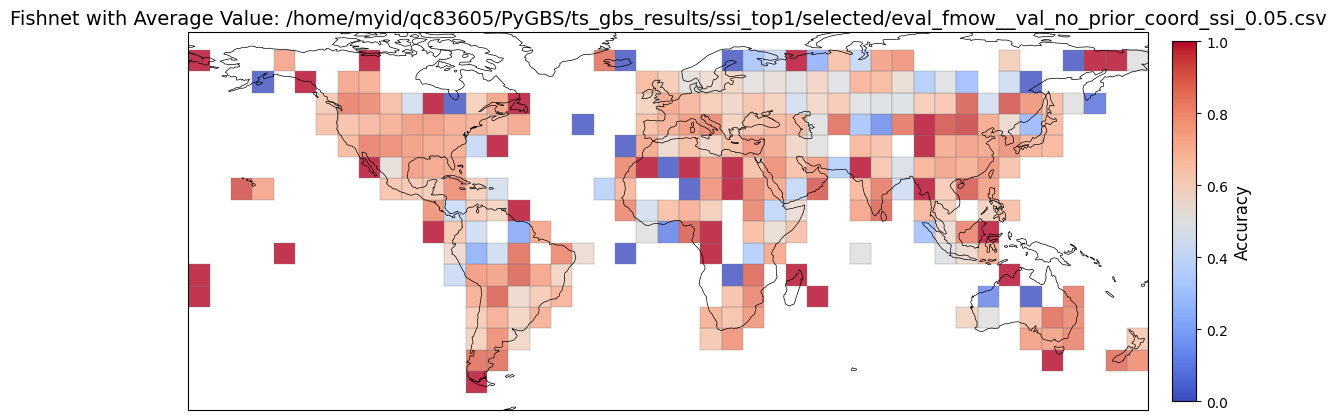

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

def create_fishnet(cell_size=1.0):
    """
    Create a fishnet (grid of polygons) that covers the whole world in PlateCarree projection.

    :param cell_size: Size of each grid cell in degrees (both latitude and longitude).
    :return: GeoDataFrame containing the grid polygons.
    """
    # Define the bounds for the whole world
    xmin, xmax, ymin, ymax = -180, 180, -90, 90

    # Create coordinates for the fishnet
    longitudes = np.arange(xmin, xmax, cell_size)
    latitudes = np.arange(ymin, ymax, cell_size)

    # Generate polygons for the grid
    polygons = []
    for lon in longitudes:
        for lat in latitudes:
            polygons.append(
                Polygon([
                    (lon, lat),
                    (lon + cell_size, lat),
                    (lon + cell_size, lat + cell_size),
                    (lon, lat + cell_size),
                    (lon, lat)
                ])
            )

    # Create a GeoDataFrame
    fishnet = gpd.GeoDataFrame({'geometry': polygons}, crs="EPSG:4326")
    return fishnet

def spatial_join_and_plot(csv_file, cell_size=1.0):
    """
    Perform a spatial join to calculate the average value and pnp_ssi for points in each grid cell.

    :param csv_file: Path to the CSV file containing 'lat', 'lon', and 'pnp_ssi' columns.
    :param cell_size: Size of each grid cell in degrees for the fishnet.
    """
    # Create the fishnet
    fishnet = create_fishnet(cell_size)

    # Load points from the CSV file
    data = pd.read_csv(csv_file)
    gdf_points = gpd.GeoDataFrame(
        data, geometry=gpd.points_from_xy(data['lon'], data['lat']), crs="EPSG:4326"
    )

    # Perform spatial join: Assign points to grid cells
    joined = gpd.sjoin(gdf_points, fishnet, how="inner")

    # Calculate the average `pnp_ssi` for each grid cell
    averages = joined.groupby('index_right').agg(
        acc=('value', 'mean')
    ).reset_index()

    # Merge averages back to the fishnet
    fishnet = fishnet.reset_index()
    fishnet = fishnet.merge(averages, left_on='index', right_on='index_right')

    # Create figure and axis
    fig = plt.figure(figsize=(12, 6))
    
    # Create main map axis with specific position
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=ccrs.PlateCarree())
    
    # Plot the fishnet with average values
    vmin = fishnet['acc'].min()
    vmax = fishnet['acc'].max()
    
    # Create the plot and store the returned mappable
    mappable = fishnet.plot(
        column='acc',
        ax=ax,
        cmap='coolwarm',
        edgecolor='gray',
        linewidth=0.3,
        alpha=0.8,
        transform=ccrs.PlateCarree(),
        missing_kwds={"color": "lightgray"},
        vmin=vmin,
        vmax=vmax,
        legend=False  # Disable the default legend
    )

    # Add map features
    ax.set_facecolor("white")
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

    # Set title
    ax.set_title(f"Fishnet with Average Value: {csv_file}", fontsize=14)

    # Create new axes for colorbar with matched height
    cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    
    # Create colorbar using the plot's scalar mappable
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    
    cbar = plt.colorbar(sm, cax=cax)
    cbar.set_label('Accuracy', fontsize=12)
    
    plt.show()

# Example usage
spatial_join_and_plot("/home/myid/qc83605/PyGBS/ts_gbs_results/ssi_top1/selected/eval_fmow__val_no_prior_coord_ssi_0.05.csv", cell_size=8)
